# Importing Libraries

In [522]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# Aggregating FRED Data

In [523]:
lf = pd.read_csv(r'/Users/ryangeorge/GitHub Projects/Unemployment-Prediction-Deep-Learning/Data/CIVPART.csv')
cpi = pd.read_csv(r'/Users/ryangeorge/GitHub Projects/Unemployment-Prediction-Deep-Learning/Data/CPIAUCSL.csv')
ir = pd.read_csv(r'/Users/ryangeorge/GitHub Projects/Unemployment-Prediction-Deep-Learning/Data/FEDFUNDS.csv')
gdp = pd.read_csv(r'/Users/ryangeorge/GitHub Projects/Unemployment-Prediction-Deep-Learning/Data/GDPC1.csv')
ipman = pd.read_csv(r'/Users/ryangeorge/GitHub Projects/Unemployment-Prediction-Deep-Learning/Data/IPMAN.csv')
unr = pd.read_csv(r'/Users/ryangeorge/GitHub Projects/Unemployment-Prediction-Deep-Learning/Data/UNRATE.csv')
velo = pd.read_csv(r'/Users/ryangeorge/GitHub Projects/Unemployment-Prediction-Deep-Learning/Data/M2V.csv')
socsec = pd.read_csv(r'/Users/ryangeorge/GitHub Projects/Unemployment-Prediction-Deep-Learning/Data/SOCSEC.csv')

## Joining CSVs together

In [524]:
df = pd.merge(lf, cpi, on='DATE')
df = pd.merge(df, ir, on='DATE')
df = pd.merge(df, gdp, on='DATE')
df = pd.merge(df, ipman, on='DATE')
df = pd.merge(df, unr, on='DATE')
df = pd.merge(df, velo, on='DATE')
df = pd.merge(df, socsec, on='DATE')

In [525]:
df.head()

,DATE,CIVPART,CPIAUCSL,FEDFUNDS,GDPC1,IPMAN,UNRATE,M2V,W823RC1
0,1972-01-01,60.300000,41.333333,3.546667,5632.649,36.211533,5.766667,1.696,38.300000
1,1972-04-01,60.400000,41.600000,4.300000,5760.470,36.959000,5.700000,1.703,38.733333
2,1972-07-01,60.466667,41.933333,4.743333,5814.854,37.466500,5.566667,1.679,39.300000
3,1972-10-01,60.366667,42.366667,5.146667,5912.220,38.890933,5.366667,1.673,47.466667
4,1973-01-01,60.433333,43.033333,6.536667,6058.544,40.181267,4.933333,1.694,49.066667


In [526]:
df.shape

(207, 9)

In [527]:
df['DATE'] = pd.to_datetime(df['DATE']) # Convert to datetime

# Data Visualization
## Subplot visualization of all parameters:

We are using subplots to visualize the data given the various scales of each of the parameters. For example Real GDP being deflated is not subject to cyclical changes like Unemployment or other indicators, thus making it harder to visualize all parameters on the same graph.

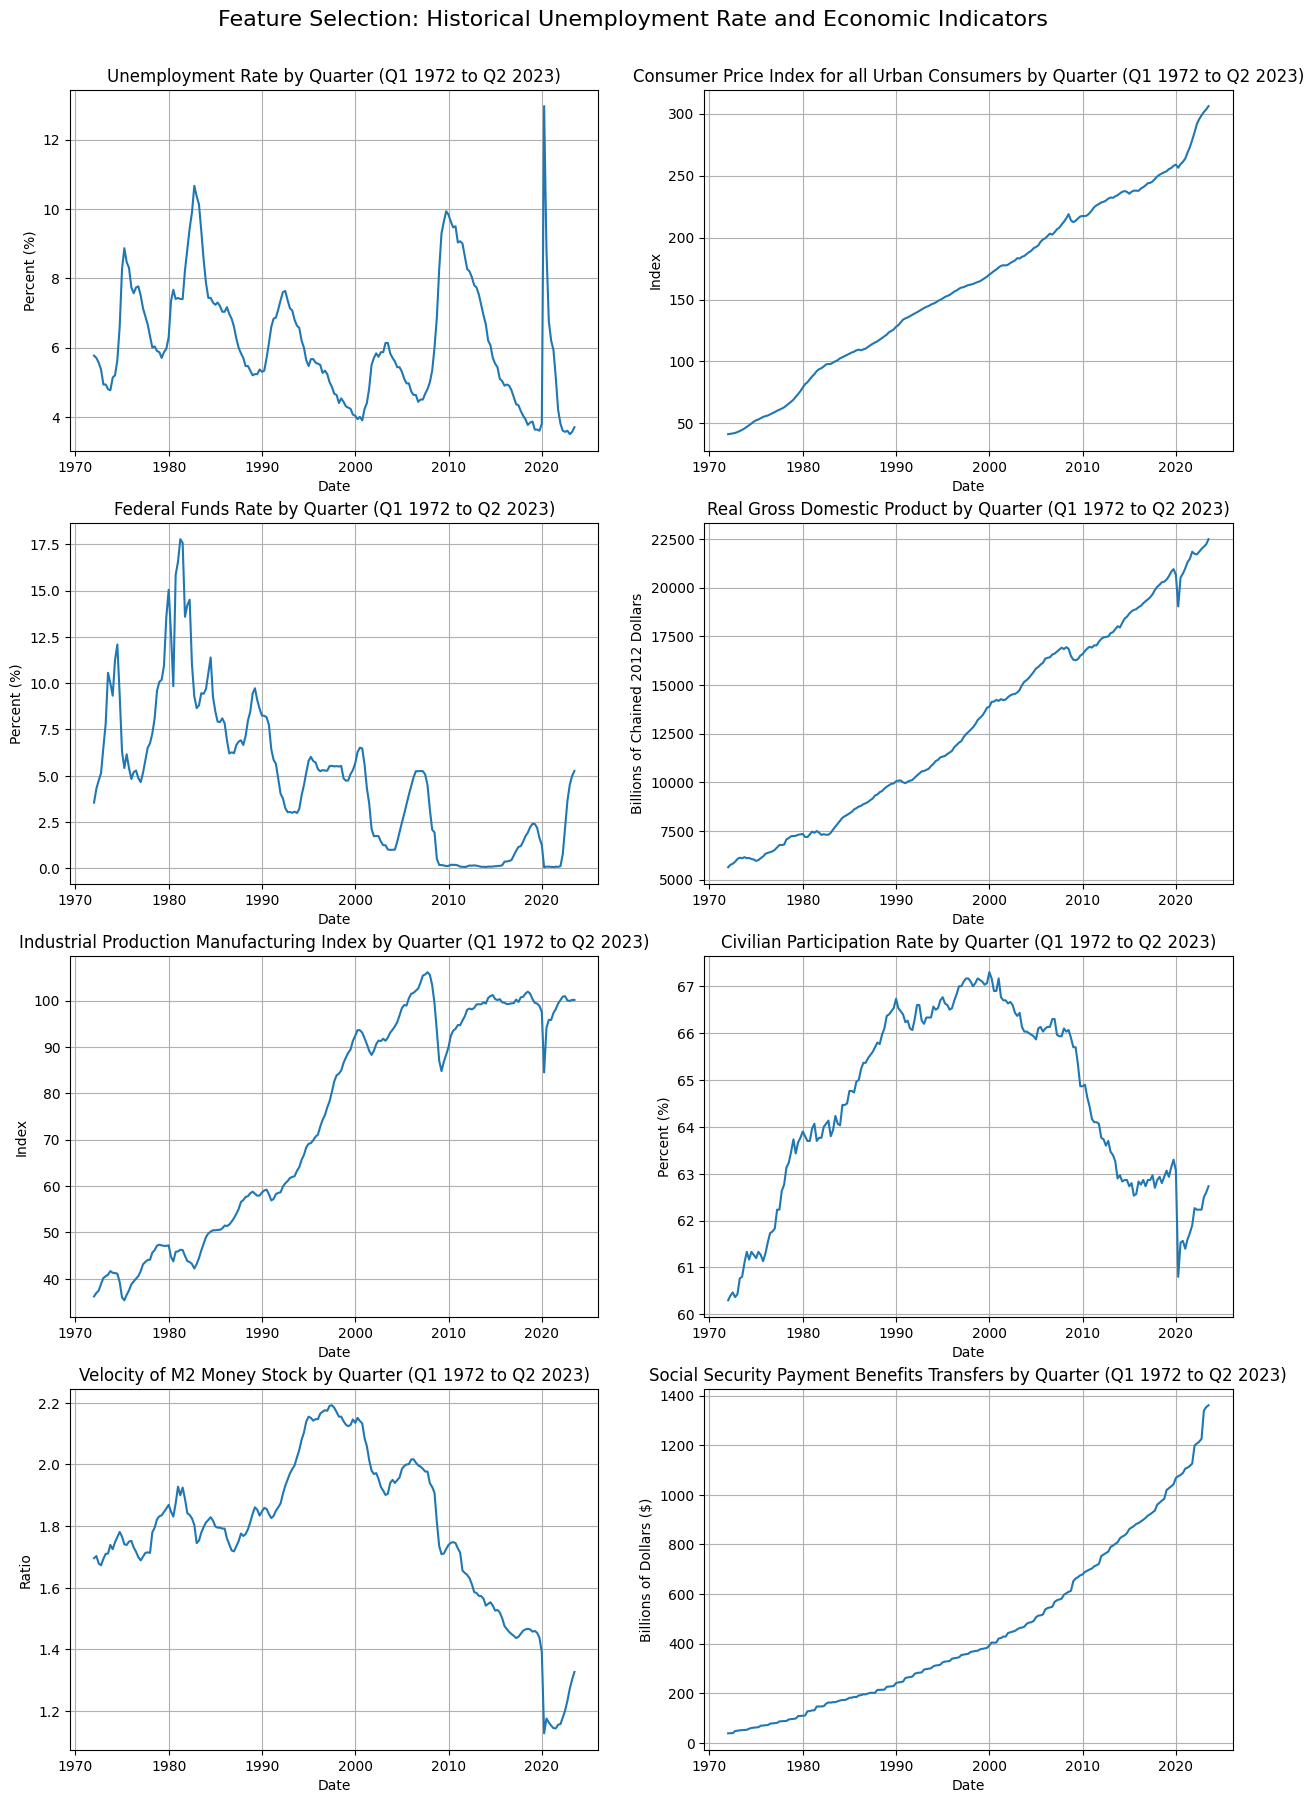

In [528]:
fig, axis = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle('Feature Selection: Historical Unemployment Rate and Economic Indicators', fontsize=16)
fig.subplots_adjust(top=0.94)  # Adjust the spacing between super title and subplots

axis[0, 0].plot(df['DATE'], df['UNRATE'])
axis[0, 0].set_title('Unemployment Rate by Quarter (Q1 1972 to Q2 2023)')
axis[0, 0].set_ylabel('Percent (%)')
axis[0, 0].set_xlabel('Date')
axis[0, 0].grid(True)

axis[0, 1].plot(df['DATE'], df['CPIAUCSL'])
axis[0, 1].set_title('Consumer Price Index for all Urban Consumers by Quarter (Q1 1972 to Q2 2023)')
axis[0, 1].set_ylabel('Index')
axis[0, 1].set_xlabel('Date')
axis[0, 1].grid(True)


axis[1, 0].plot(df['DATE'], df['FEDFUNDS'])
axis[1, 0].set_title('Federal Funds Rate by Quarter (Q1 1972 to Q2 2023)')
axis[1, 0].set_ylabel('Percent (%)')
axis[1, 0].set_xlabel('Date')
axis[1, 0].grid(True)


axis[1, 1].plot(df['DATE'], df['GDPC1'])
axis[1, 1].set_title('Real Gross Domestic Product by Quarter (Q1 1972 to Q2 2023)')
axis[1, 1].set_ylabel('Billions of Chained 2012 Dollars')
axis[1, 1].set_xlabel('Date')
axis[1, 1].grid(True)

axis[2, 0].plot(df['DATE'], df['IPMAN'])
axis[2, 0].set_title('Industrial Production Manufacturing Index by Quarter (Q1 1972 to Q2 2023)')
axis[2, 0].set_ylabel('Index')
axis[2, 0].set_xlabel('Date')
axis[2, 0].grid(True)

axis[2, 1].plot(df['DATE'], df['CIVPART'])
axis[2, 1].set_title('Civilian Participation Rate by Quarter (Q1 1972 to Q2 2023)')
axis[2, 1].set_ylabel('Percent (%)')
axis[2, 1].set_xlabel('Date')
axis[2, 1].grid(True)


axis[3, 0].plot(df['DATE'], df['M2V'])
axis[3, 0].set_title('Velocity of M2 Money Stock by Quarter (Q1 1972 to Q2 2023)')
axis[3, 0].set_ylabel('Ratio')
axis[3, 0].set_xlabel('Date')
axis[3, 0].grid(True)

axis[3, 1].plot(df['DATE'], df['W823RC1'])
axis[3, 1].set_title('Social Security Payment Benefits Transfers by Quarter (Q1 1972 to Q2 2023)')
axis[3, 1].set_ylabel('Billions of Dollars ($)')
axis[3, 1].set_xlabel('Date')
axis[3, 1].grid(True)


## Correlation Matrix: 

In [529]:
data = df.iloc[:,1:] # Remove date column
corr_data = data.corr() # Calculate correlation matrix

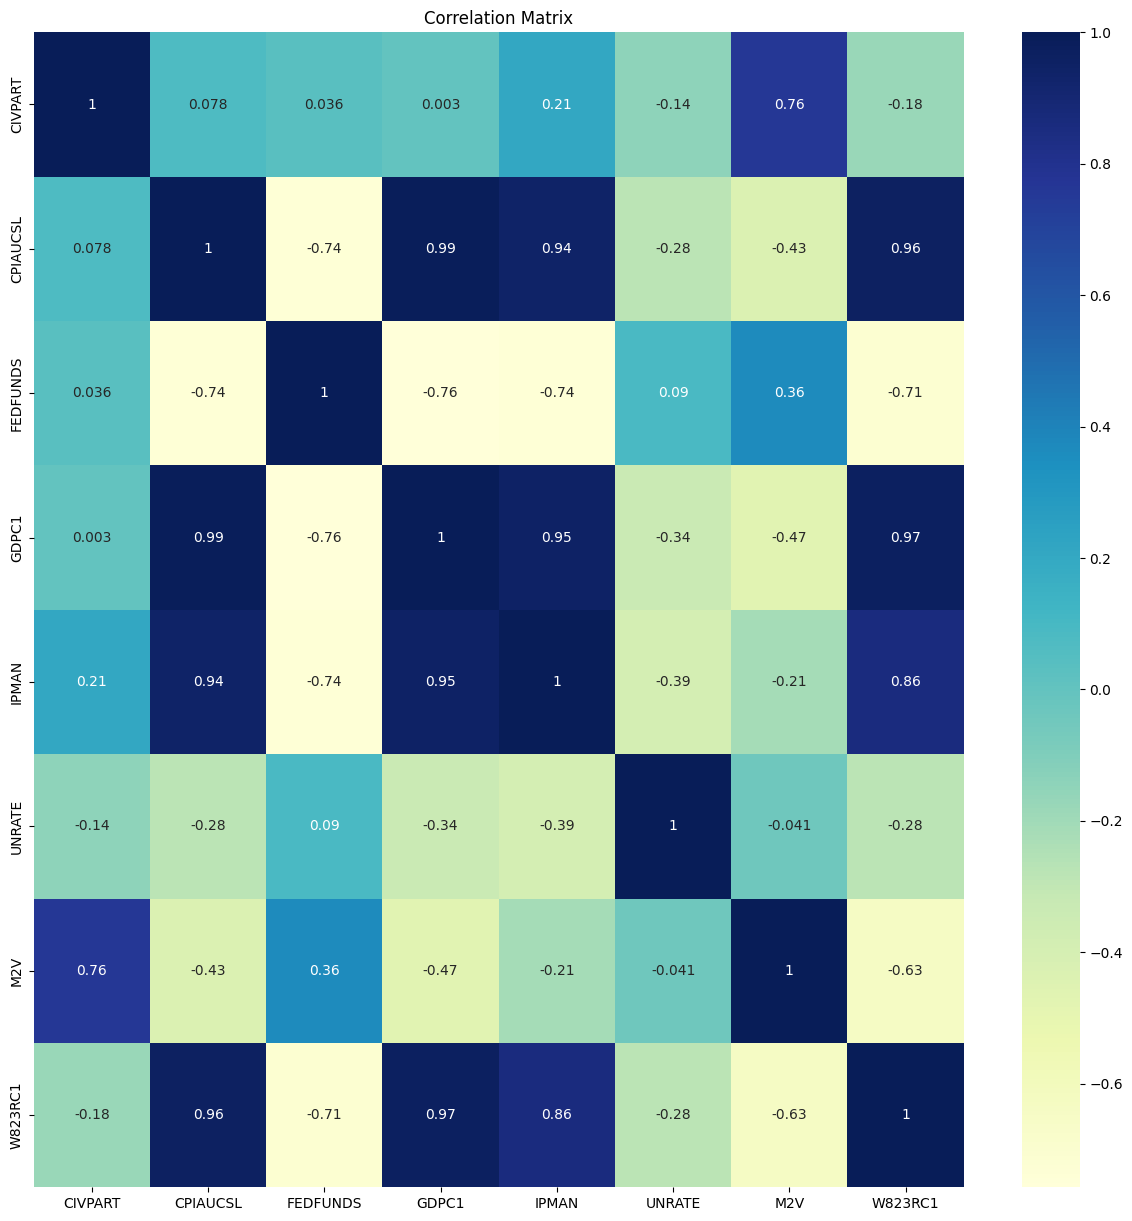

In [530]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_data, annot=True, cmap='YlGnBu',xticklabels=data.columns, yticklabels=data.columns)
plt.title('Correlation Matrix')
plt.show()

# LSTM Implementation:

In [531]:
cols = list(df)[1:9]
df_training = df[cols].astype(float)
y_training = df_training['UNRATE'].astype(float)

In [532]:
scaler = RobustScaler()
scaler.fit(df_training)
df_training_scaled = scaler.transform(df_training)

y_training = y_training.values.reshape(-1,1)
scaler.fit(y_training)
y_training_scaled = scaler.transform(y_training)

In [533]:
TrainX = []
TrainY = []

n_future = 4 # Number of quarters we want to predict into the future
n_past = 32 # Number of years in quarters we want to use to predict the future

for i in range(n_past, len(df_training_scaled) - n_future +1):
    TrainX.append(df_training_scaled[i - n_past:i, 0:df_training.shape[1]])
    TrainY.append(df_training_scaled[i + n_future - 1:i + n_future, 0])

TrainX, TrainY = np.array(TrainX), np.array(TrainY)

In [534]:
X_train, X_test, y_train, y_test = train_test_split(TrainX, TrainY, test_size=0.2, shuffle=False, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False, random_state=42)

In [535]:
model = Sequential()
model.add(LSTM(25, input_shape=(TrainX.shape[1], TrainX.shape[2]), return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(layers.Activation('relu'))
model.add(Dense(1))

In [536]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 25)                3400      
                                                                 
 batch_normalization_16 (Ba  (None, 25)                100       
 tchNormalization)                                               
                                                                 
 dropout_16 (Dropout)        (None, 25)                0         
                                                                 
 activation_16 (Activation)  (None, 25)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 26        
                                                                 
Total params: 3526 (13.77 KB)
Trainable params: 3476 (13.58 KB)
Non-trainable params: 50 (200.00 Byte)
________________

In [537]:
model.fit(TrainX, TrainY, epochs = 30, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/30
9/9 [==============================] - 1s 25ms/step - loss: 0.9576 - val_loss: 0.2431
Epoch 2/30
9/9 [==============================] - 0s 4ms/step - loss: 0.7151 - val_loss: 0.2290
Epoch 3/30
9/9 [==============================] - 0s 4ms/step - loss: 0.7264 - val_loss: 0.2515
Epoch 4/30
9/9 [==============================] - 0s 4ms/step - loss: 0.6849 - val_loss: 0.2681
Epoch 5/30
9/9 [==============================] - 0s 4ms/step - loss: 0.5590 - val_loss: 0.2771
Epoch 6/30
9/9 [==============================] - 0s 4ms/step - loss: 0.4922 - val_loss: 0.3061
Epoch 7/30
9/9 [==============================] - 0s 4ms/step - loss: 0.5781 - val_loss: 0.3133
Epoch 8/30
9/9 [==============================] - 0s 4ms/step - loss: 0.4199 - val_loss: 0.2950
Epoch 9/30
9/9 [==============================] - 0s 4ms/step - loss: 0.4442 - val_loss: 0.2546
Epoch 10/30
9/9 [==============================] - 0s 4ms/step - loss: 0.4922 - val_loss: 0.2551
Epoch 11/30
9/9 [=====================

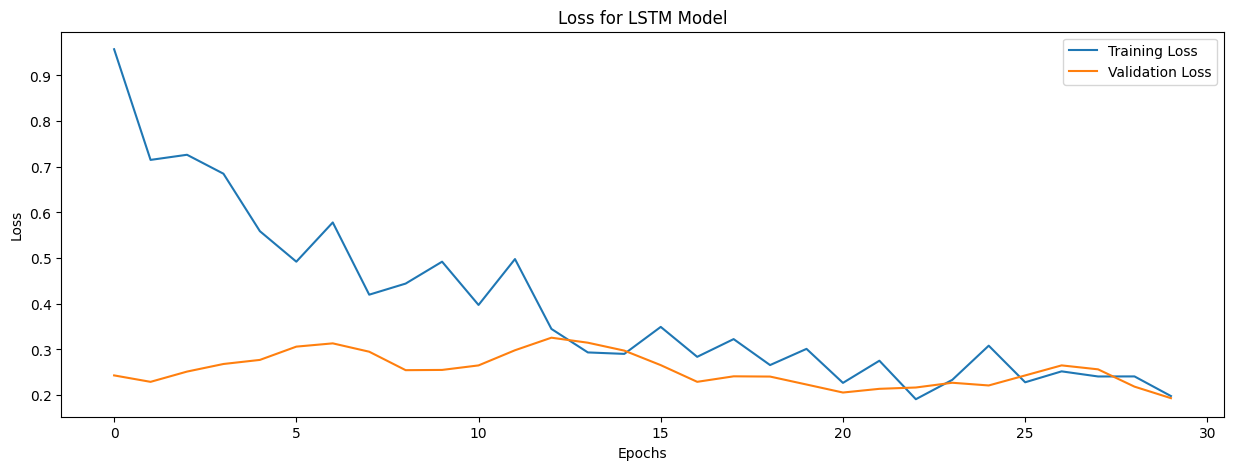

In [538]:
# Visualize the loss
plt.figure(figsize=(15, 5))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Loss for LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Model Evaluation:

## Forecasting:

In [539]:
n_quarters_pred = 9
forecast_period_dates = pd.date_range(list(df['DATE'])[-1], periods=n_quarters_pred, freq='Q').tolist()

In [540]:
forecast = model.predict(TrainX[-n_future:]) # Forecast

1/1 [==============================] - 0s 156ms/step


In [541]:
forecast_copies = np.repeat(forecast, df_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [542]:
forecast_dates = []

for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [543]:
n_quarters_pred = forecast.shape[0]
forecast_period_dates = pd.date_range(list(df['DATE'])[-1], periods=n_quarters_pred+1, freq='Q').tolist()
df_forecast = pd.DataFrame({'Date':np.array(forecast_period_dates[1:]), 'UNRATE':y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [544]:
df_forecast

,Date,UNRATE
0,2023-12-31,4.913239
1,2024-03-31,4.951100
2,2024-06-30,4.980532
3,2024-09-30,4.998269


In [545]:
original = df[['DATE', 'UNRATE']]
original['DATE'] = pd.to_datetime(original['DATE'])
original = original.loc[original['DATE'] >= '2018-01-01']

/var/folders/j_/zl034w1d0_jbky1392t7mm_40000gn/T/ipykernel_93475/1822723035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['DATE'] = pd.to_datetime(original['DATE'])


### Unemployment Rate Forecast Visualization

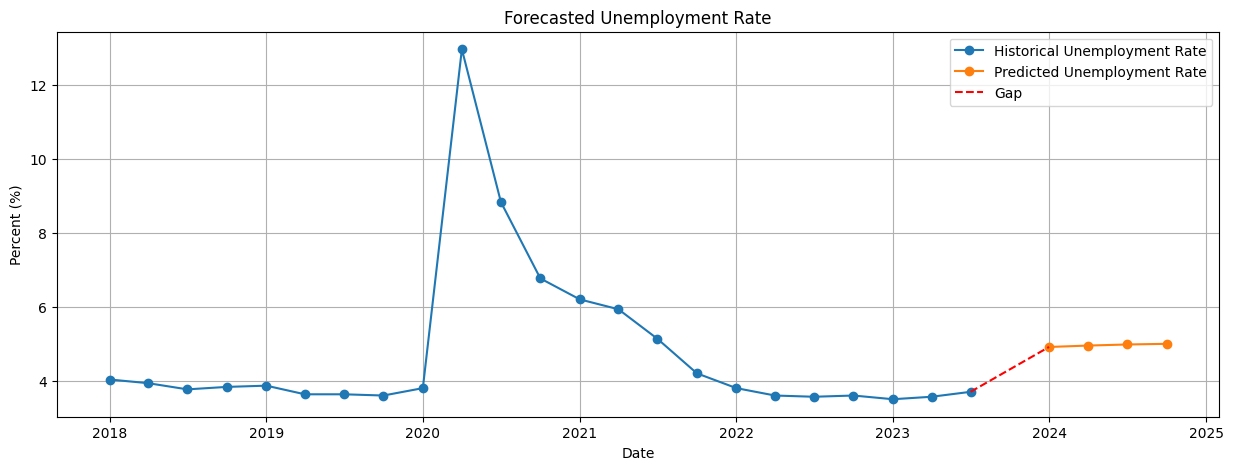

In [546]:
original = pd.DataFrame(original)
forecast_df = pd.DataFrame(df_forecast)

# Plot historical and forecasted data
plt.figure(figsize=(15, 5))
plt.plot(original['DATE'], original['UNRATE'], label='Historical Unemployment Rate', marker='o')
plt.plot(forecast_df['Date'], forecast_df['UNRATE'], label='Predicted Unemployment Rate', marker='o')

# Add a dashed line to indicate the gap
gap_index = len(original) - 1
plt.plot([original['DATE'].iloc[gap_index], forecast_df['Date'].iloc[0]], [original['UNRATE'].iloc[gap_index], forecast_df['UNRATE'].iloc[0]], 'r--', label='Gap')

plt.title('Forecasted Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Percent (%)')
plt.legend()
plt.grid(True)

plt.show()

## Predicted vs Actual Unemployment Rate:

In [547]:
predictions = model.predict(TrainX) 

# Inverse transform to scale back to original range
predictions = scaler.inverse_transform(predictions)
y_train_scaled = scaler.inverse_transform(TrainY)

predictions = pd.DataFrame(predictions, columns=['Predictions'])



1/6 [====>.........................] - ETA: 0s

6/6 [==============================] - 0s 6ms/step


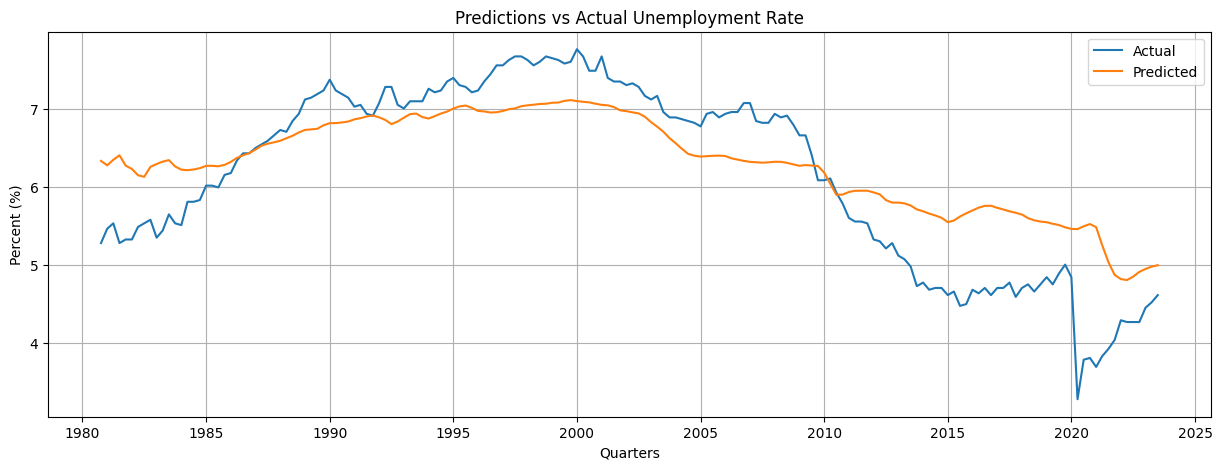

In [548]:
# Get quarters to date
quarters = df['DATE'].values
quarters = quarters[-len(y_train_scaled):]
quarters = pd.DataFrame(quarters, columns=['DATE'])

# Plot predictions vs actual
plt.figure(figsize=(15, 5))
plt.plot(quarters, y_train_scaled, label='Actual')
plt.plot(quarters, predictions, label='Predicted')
plt.title('Predictions vs Actual Unemployment Rate')
plt.xlabel('Quarters')
plt.ylabel('Percent (%)')
plt.legend()
plt.grid(True)



## Model Robustness Evaluation:

### Mean Squared Error (MSE):

In [549]:
from sklearn.metrics import mean_squared_error

mean_squared = mean_squared_error(y_train_scaled, predictions).tolist()
print('Mean Squared Error:', mean_squared)

Mean Squared Error: 0.4248483125859251


#### Root Mean Squared Error (RMSE):

In [550]:
rmse = np.sqrt(mean_squared)
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 0.6518038912018899


### Mean Absolute Error (MAE):

In [551]:
from sklearn.metrics import mean_absolute_error

mean_absolute = mean_absolute_error(y_train_scaled, predictions).tolist()
print('Mean Absolute Error:', mean_absolute)

Mean Absolute Error: 0.5459157222135714


In [554]:
# Comparing to a moving average
moving_avg = df['UNRATE'].rolling(4).mean()
moving_avg = moving_avg[-len(y_train_scaled):]

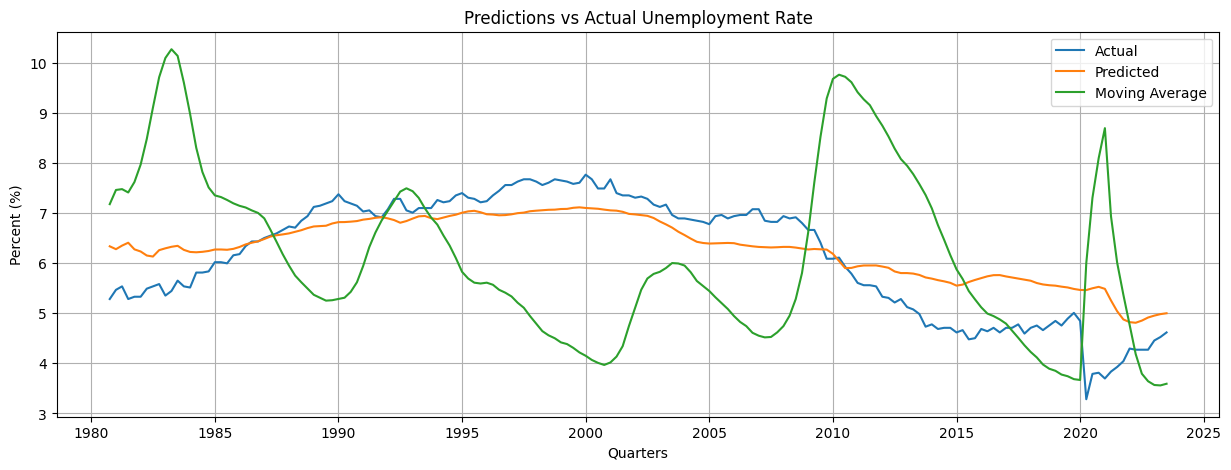

In [555]:
# Plot predictions vs actual
plt.figure(figsize=(15, 5))
plt.plot(quarters, y_train_scaled, label='Actual')
plt.plot(quarters, predictions, label='Predicted')
plt.plot(quarters, moving_avg, label='Moving Average')
plt.title('Predictions vs Actual Unemployment Rate')
plt.xlabel('Quarters')
plt.ylabel('Percent (%)')
plt.legend()
plt.grid(True)

In [566]:
# Comparing to VAR model
from statsmodels.tsa.api import VAR

df_var = df[['DATE', 'UNRATE', 'CPIAUCSL', 'FEDFUNDS', 'GDPC1', 'IPMAN', 'M2V', 'W823RC1']]
df_var['DATE'] = pd.to_datetime(df_var['DATE'])
df_var = df_var.set_index('DATE')
df_var = df_var.diff().dropna()

var_model = VAR(df_var)
var_results = var_model.fit(4)
var_results.summary()

var_forecast = var_results.forecast(df_var.values[-4:], 4)
var_forecast = pd.DataFrame(var_forecast, columns=df_var.columns)
var_forecast['UNRATE'] = var_forecast['UNRATE'].cumsum().add(df['UNRATE'].iloc[-5])
var_forecast = var_forecast[['UNRATE']]

# Transform index to datetime
var_forecast.index = pd.date_range(df['DATE'].iloc[-1], periods=4, freq='Q').tolist()


/var/folders/j_/zl034w1d0_jbky1392t7mm_40000gn/T/ipykernel_93475/1109731862.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var['DATE'] = pd.to_datetime(df_var['DATE'])
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [567]:
print(var_forecast) 
print(df_forecast)

              UNRATE
2023-09-30  3.788863
2023-12-31  3.653080
2024-03-31  4.377800
2024-06-30  3.839868
        Date    UNRATE
0 2023-12-31  4.913239
1 2024-03-31  4.951100
2 2024-06-30  4.980532
3 2024-09-30  4.998269


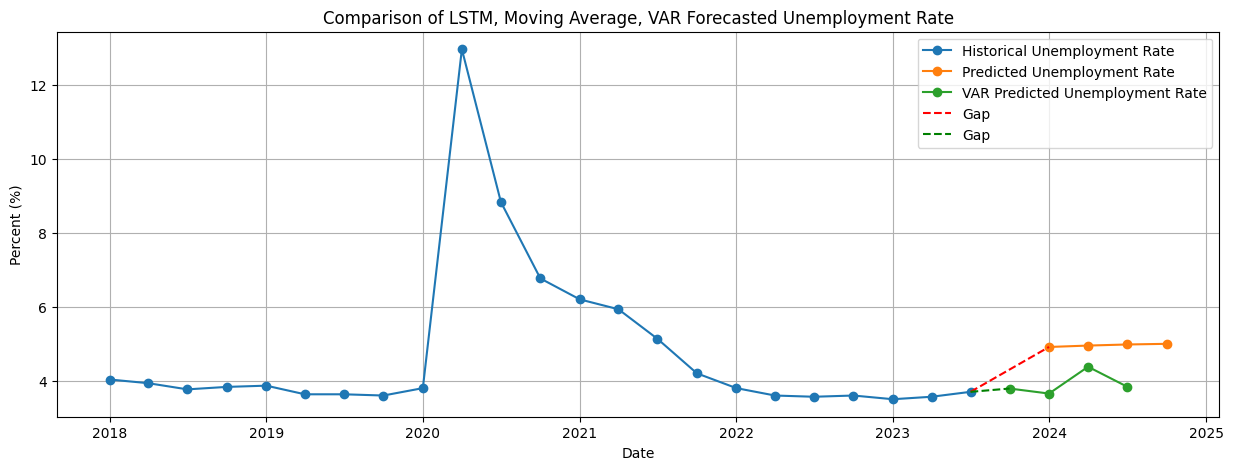

In [574]:
# Plot historical and forecasted data
plt.figure(figsize=(15, 5))
plt.plot(original['DATE'], original['UNRATE'], label='Historical Unemployment Rate', marker='o')
plt.plot(forecast_df['Date'], forecast_df['UNRATE'], label='Predicted Unemployment Rate', marker='o')
plt.plot(var_forecast.index, var_forecast['UNRATE'], label='VAR Predicted Unemployment Rate', marker='o')

# Add a dashed line to indicate the gap
gap_index = len(original) - 1
plt.plot([original['DATE'].iloc[gap_index], forecast_df['Date'].iloc[0]], [original['UNRATE'].iloc[gap_index], forecast_df['UNRATE'].iloc[0]], 'r--', label='Gap')

# Add a dashed line to indicate the gap
gap_index = len(original) - 1
plt.plot([original['DATE'].iloc[gap_index], var_forecast.index[0]], [original['UNRATE'].iloc[gap_index], var_forecast['UNRATE'].iloc[0]], 'g--', label='Gap')

plt.title('Comparison of LSTM, Moving Average, VAR Forecasted Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Percent (%)')
plt.legend()
plt.grid(True)

plt.show()

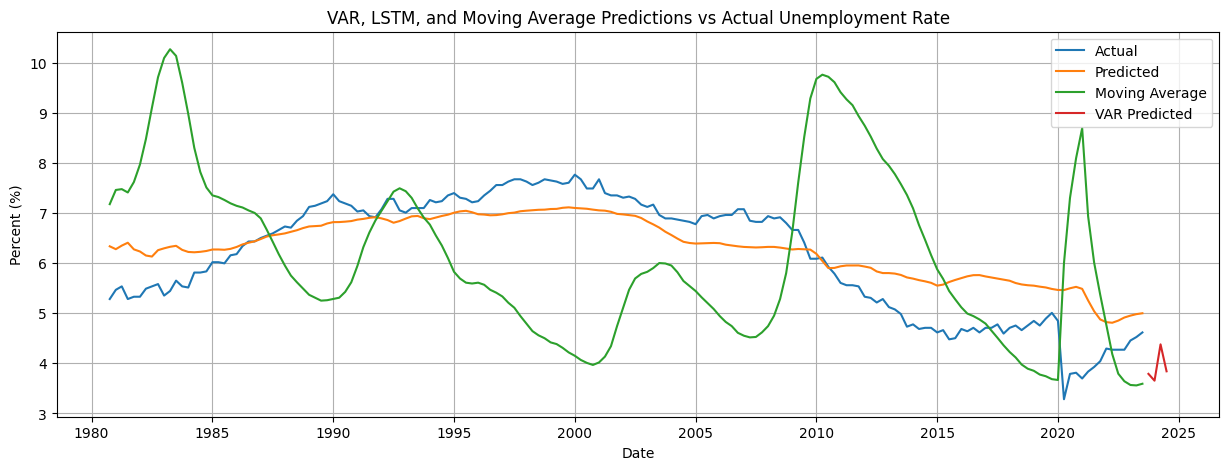

In [573]:
# VAR predicted vs actual
plt.figure(figsize=(15, 5))
plt.plot(quarters, y_train_scaled, label='Actual')
plt.plot(quarters, predictions, label='Predicted')
plt.plot(quarters, moving_avg, label='Moving Average')
plt.plot(var_forecast.index, var_forecast['UNRATE'], label='VAR Predicted')
plt.title('VAR, LSTM, and Moving Average Predictions vs Actual Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Percent (%)')
plt.legend()
plt.grid(True)


# Saving the Model

In [553]:
saving = model.save('lstm_model.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
